In [143]:
# third party
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import scipy
import torch

In [ ]:
# Filenames and directories
MODULE_DIR = "other_prediction_functions"
INPUT_SQ_DIR = "a. Input time series sequences"
# same as in Matlab repo, could be improved later: load from json and remove RNN
VAR_OUT_DIR = "models"

# if True, use ETH data as training set and Magdeburg data as test set, otherwise that's the contrary
USE_ETH_DATA_AS_TRAINING = False

horizon = 1
n_models = 10
num_epochs = 300
learning_rate = 0.0001
early_stop_patience = 30  # 20
print_every = 10
init_seed = 42  # the seed of the first model to train
selected_device = "cuda"  # choose between "cuda" or "cpu"

# Model parameters
d_model = 16  # Embedding dimension
nhead = 2  # Number of heads in multi-head attention
num_layers = 2  # Number of transformer layers
dim_feedforward = 16  # Dimension of feedforward network
dropout = 0.5  # Dropout rate (now explicit)
final_layer_dim = None  # Dimension of the final hidden linear layer, None sets it to geometric mean of input and output

# Hyperparameters
seq_length = 24  # Input sequence length
training_fraction = 0.8  # Fraction of data used for training
batch_size = 32

# Parameters we use for data augmentaiton
scaling_range = (0.8, 1.2)  # Random amplitude scaling
permutation_prob = 0.5  # Probability of dimension permutation
drift_prob = 0.3  # Probability of adding baseline drift
max_drift_factor = 0.05  # Maximum drift (as fraction of signal amplitude)
bias_prob = 0.3  # Probability of adding baseline bias
max_bias_factor = 0.2  # Maximum bias (as fraction of signal amplitude

# Index of the model we want to test and for which we plot predictions - cf test section of the notebook
test_model_idx = 0

# Index of the sequence in the test set we use as an example for testing - cf test section of the notebook
test_sequence_idx = 0

In [145]:
folders = {
    "dev_folders": [
        "2. sq sl010 sag Xcs=125 3 cpts 2024 normalised",
        "3. sq sl010 sag Xcs=80 3 cpts 2024 normalised",
        "4. sq sl014 sag Xcs=165 3 cpts 2024 normalised",
        "5. sq sl014 sag Xcs=95 3 cpts 2024 normalised",
    ],
    "test_folders": [
        "2020-11-10_KS81_Nav_Pur_1_3_cpts",
        "2020-11-12_QN76_Nav_Pur_1_3_cpts",
        "2020-11-17_CS31_Nav_Pur_2_3_cpts",
        "2020-11-17_JY02_Nav_Pur_2_3_cpts",
        "2020-11-23_ON65_Nav_Pur_2_3_cpts",
        "2020-11-23_PS11_Nav_Pur_1_3_cpts",
        "2020-11-25_II29_Nav_Pur_1_3_cpts",
        "2020-11-26_NE38_Nav_Pur_1_3_cpts",
    ],
}

# Resampling parameters
dev_freq_hz = 3.18  # eth dataset sampling frequency
test_freq_hz = 6.0  # magdeburg dataset sampling frequency

if USE_ETH_DATA_AS_TRAINING:
    adaptation_window = 160  # corresponds to pred_par.tmax_training for the Magdeburg dataset (here used as test set)
    dataset_out_dirname = "training_with_eth_dataset"
else:
    folders["dev_folders"], folders["test_folders"] = folders["test_folders"], folders["dev_folders"]
    dev_freq_hz, test_freq_hz = test_freq_hz, dev_freq_hz
    adaptation_window = 303  # corresponds to pred_par.tmax_training for the ETH dataset (here used as test set)
    dataset_out_dirname = "training_with_magdeburg_dataset"

In [146]:
import sys
import os

# Get the current notebook's directory
notebook_dir = os.getcwd()

# Construct the relative path to the module
module_dir = os.path.join(notebook_dir, "..", MODULE_DIR)

# Add to sys.path if not already included
if module_dir not in sys.path:
    sys.path.append(module_dir)

# Importing the module for transformer forecasting
import transformers_forecasting as tf  # type: ignore

Loading the data


In [147]:
# Loading data
workspace_dir = os.path.dirname(notebook_dir)
for folder_type, folders_list in folders.items():
    folders[folder_type] = [os.path.join(workspace_dir, INPUT_SQ_DIR, folder) for folder in folders_list]

raw_data, n_features = tf.load_dev_test_data(**folders)

Loading development data from /mnt/d/MRI_prediction/Time_series_forecasting/a. Input time series sequences/2020-11-10_KS81_Nav_Pur_1_3_cpts...
Loading development data from /mnt/d/MRI_prediction/Time_series_forecasting/a. Input time series sequences/2020-11-12_QN76_Nav_Pur_1_3_cpts...
Loading development data from /mnt/d/MRI_prediction/Time_series_forecasting/a. Input time series sequences/2020-11-17_CS31_Nav_Pur_2_3_cpts...
Loading development data from /mnt/d/MRI_prediction/Time_series_forecasting/a. Input time series sequences/2020-11-17_JY02_Nav_Pur_2_3_cpts...
Loading development data from /mnt/d/MRI_prediction/Time_series_forecasting/a. Input time series sequences/2020-11-23_ON65_Nav_Pur_2_3_cpts...
Loading development data from /mnt/d/MRI_prediction/Time_series_forecasting/a. Input time series sequences/2020-11-23_PS11_Nav_Pur_1_3_cpts...
Loading development data from /mnt/d/MRI_prediction/Time_series_forecasting/a. Input time series sequences/2020-11-25_II29_Nav_Pur_1_3_cpts...

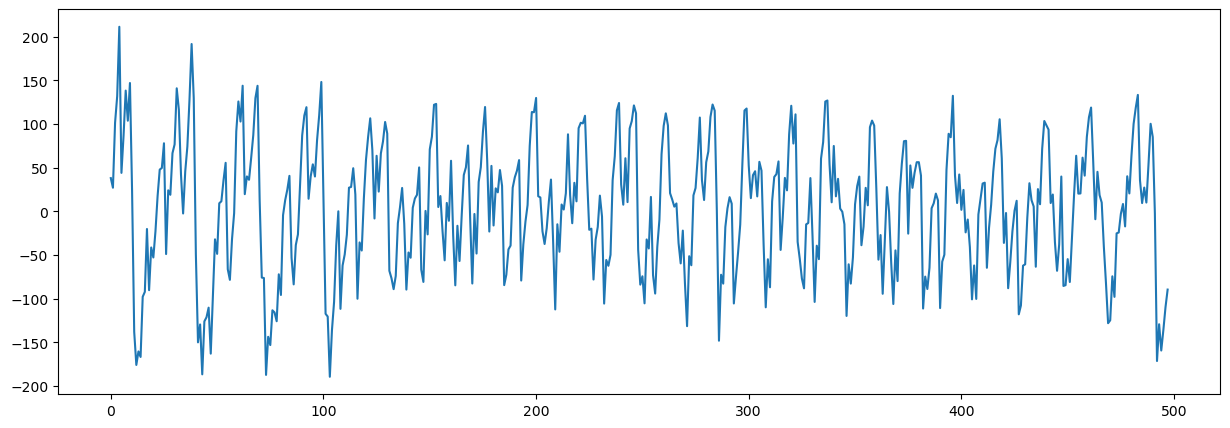

In [148]:
# plotting the original data - modify the sequence index and coordinate you want to plot
sequence_idx = 0
crd_idx = 1

plt.figure(figsize=(15, 5))
plt.plot(raw_data["dev_data"][sequence_idx][crd_idx].T)
plt.show()

Resampling the data


In [149]:
# Resample data if frequencies differ
if dev_freq_hz != test_freq_hz:
    resampled_dev_data = tf.resample_data_poly(raw_data["dev_data"], dev_freq_hz, test_freq_hz)

resampled_data = raw_data.copy()
resampled_data["dev_data"] = resampled_dev_data

Resampling with ratio 6.0/3.18 = 100/53
Resampled dev signal 1: 498 → 264 samples (expected ~263)
Resampled dev signal 2: 498 → 264 samples (expected ~263)
Resampled dev signal 3: 498 → 264 samples (expected ~263)
Resampled dev signal 4: 498 → 264 samples (expected ~263)
Resampled dev signal 5: 498 → 264 samples (expected ~263)
Resampled dev signal 6: 498 → 264 samples (expected ~263)
Resampled dev signal 7: 498 → 264 samples (expected ~263)
Resampled dev signal 8: 498 → 264 samples (expected ~263)


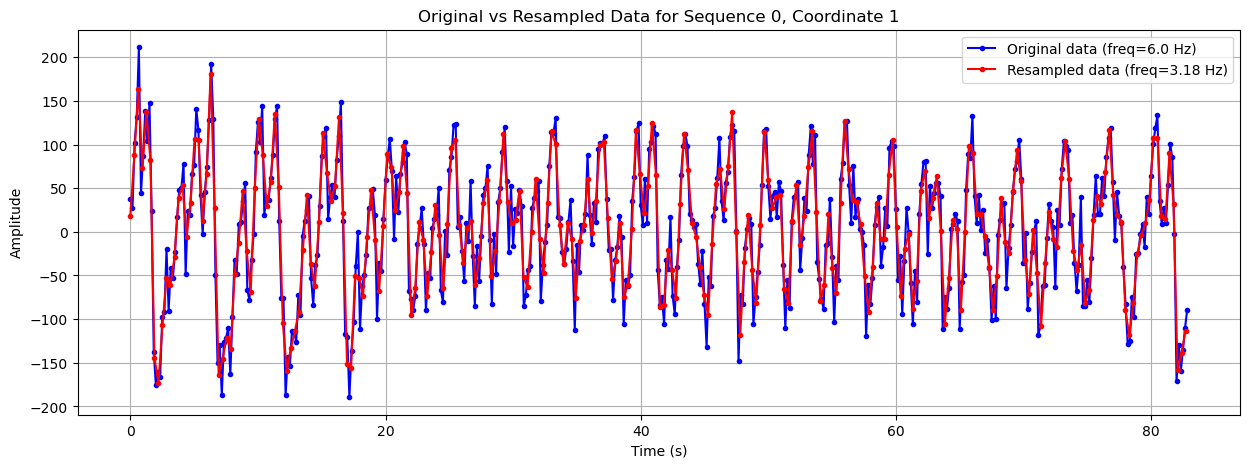

In [150]:
# plotting the original against the resampled data to check that resampling worked
org_sq = raw_data["dev_data"][sequence_idx][crd_idx].T
resampled_sq = resampled_dev_data[sequence_idx][crd_idx].T

# plot inspired by https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample_poly.html
t = np.linspace(0, (1 / dev_freq_hz) * org_sq.shape[0], org_sq.shape[0], endpoint=False)
t_new = np.linspace(0, (1 / test_freq_hz) * resampled_sq.shape[0], resampled_sq.shape[0], endpoint=False)

plt.figure(figsize=(15, 5))
plt.plot(
    t,
    raw_data["dev_data"][sequence_idx][crd_idx].T,
    "b.-",
    label=f"Original data (freq={dev_freq_hz} Hz)",
)
plt.plot(t_new, resampled_dev_data[sequence_idx][crd_idx].T, "r.-", label=f"Resampled data (freq={test_freq_hz} Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"Original vs Resampled Data for Sequence {sequence_idx}, Coordinate {crd_idx}")
plt.legend()
plt.grid()
plt.show()

In [151]:
# Preprocessing data and splitting the data into pairs of unput and target values
standardized_data, scaler = tf.preprocess_data(resampled_data, horizon, seq_length, training_fraction)

# Getting pytorch data loaders
data_loaders = tf.get_population_data_loaders(standardized_data, batch_size=batch_size)

train set: Added 187 sequences
train set: Added 187 sequences
train set: Added 187 sequences
train set: Added 187 sequences
train set: Added 187 sequences
train set: Added 187 sequences
train set: Added 187 sequences
train set: Added 187 sequences
val set: Added 29 sequences
val set: Added 29 sequences
val set: Added 29 sequences
val set: Added 29 sequences
val set: Added 29 sequences
val set: Added 29 sequences
val set: Added 29 sequences
val set: Added 29 sequences
test set: Added 176 sequences
test set: Added 176 sequences
test set: Added 176 sequences
test set: Added 176 sequences
Train loader: 1496 sequences
Val loader: 232 sequences
Test loader: 704 sequences


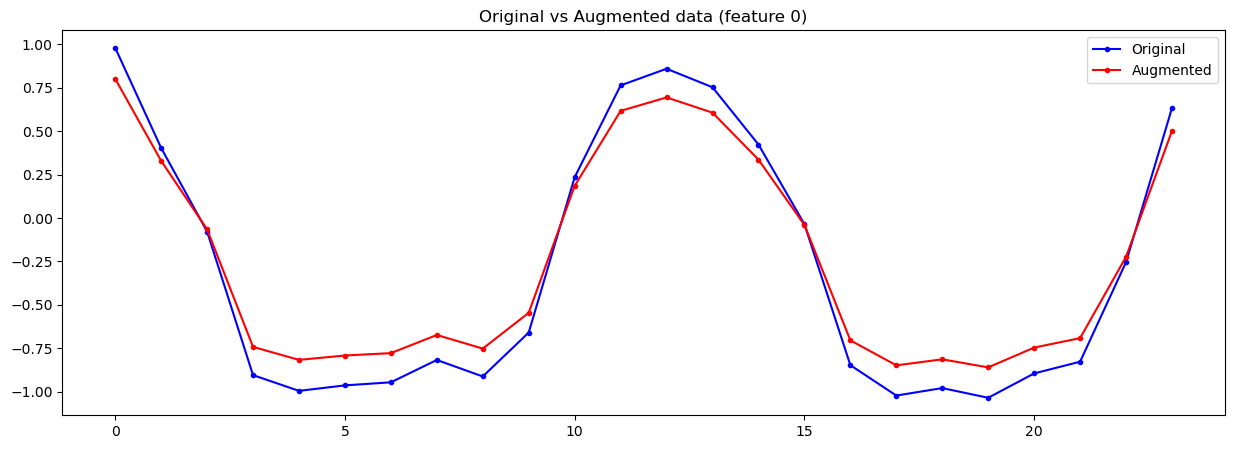

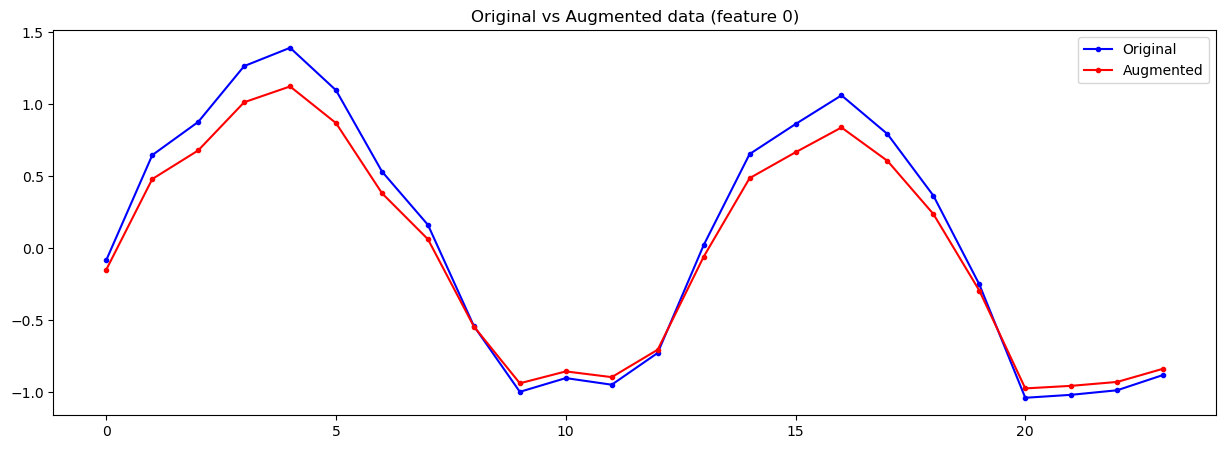

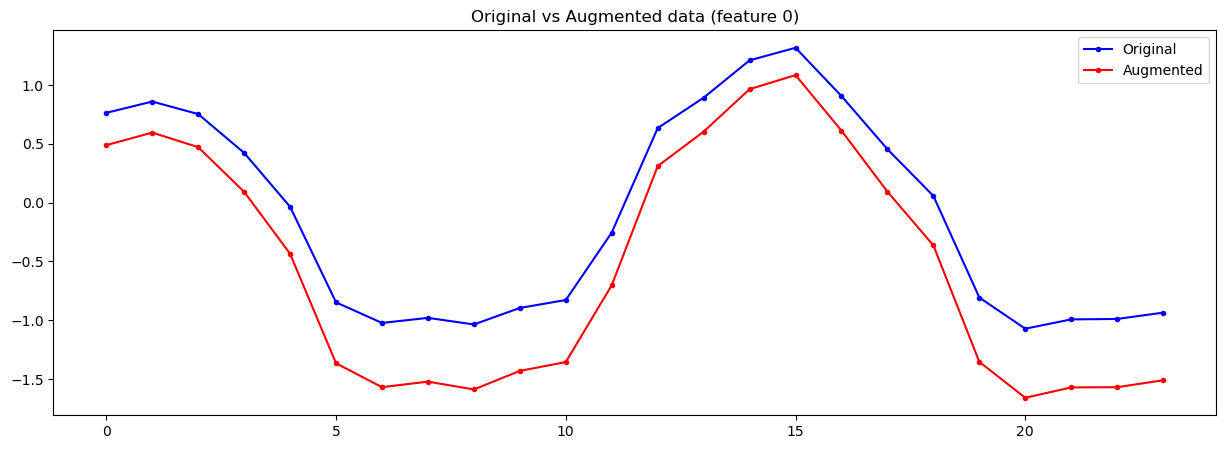

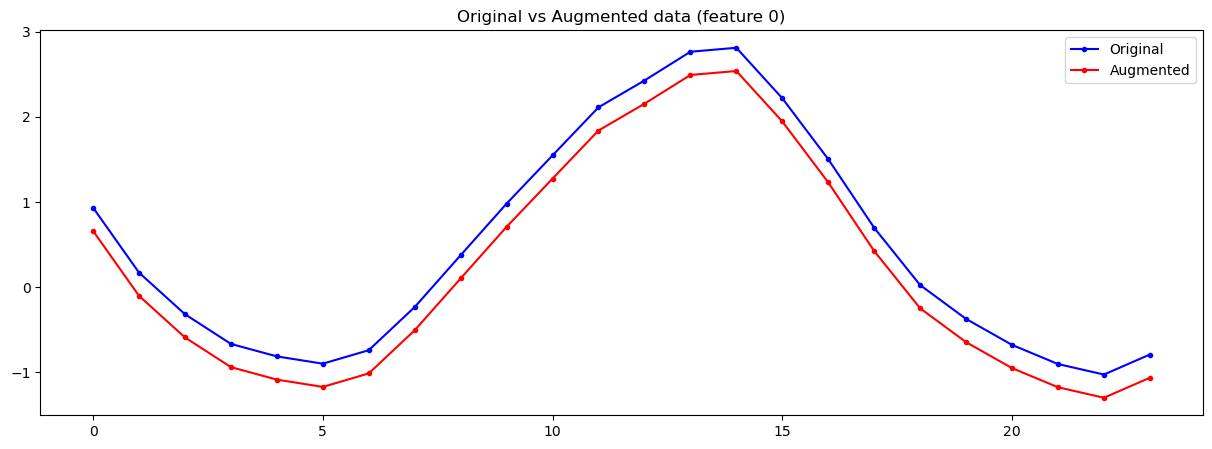

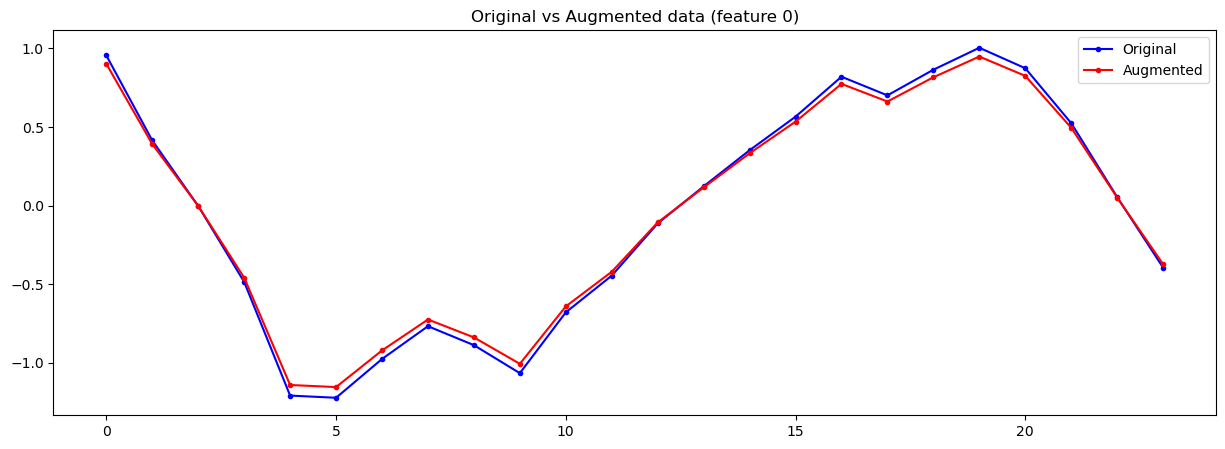

In [152]:
# Rerun the cell several times to get different batches and targets
# Trying to plot augmentation of the data - as a demonstration

# Parameters to play with by hand
tmp_config = {
    "scaling_range": (0.8, 1.2),  # Random amplitude scaling
    "permutation_prob": 0.0,  # Probability of dimension permutation
    "drift_prob": 0.3,  # Probability of adding baseline drift
    "max_drift_factor": 0.05,  # Maximum drift (as fraction of signal amplitude)
    "bias_prob": 0.3,  # Probability of adding baseline bias
    "max_bias_factor": 0.2,  # Maximum bias (as fraction of signal amplitude
}
nb_plts = 5
feature_idx = 0

for _ in range(nb_plts):
    train_batch_inputs, train_batch_targets = next(iter(data_loaders["train"]))

    # Doing the augmentation
    augmented_batch_inputs, augmented_batch_targets = tf.time_series_augmentation_suite(
        train_batch_inputs, train_batch_targets, config=tmp_config
    )
    idx_in_batch = 0

    # Plotting the original and augmented data
    plt.figure(figsize=(15, 5))
    plt.plot(train_batch_inputs[idx_in_batch, :, feature_idx].T, "b.-", label="Original")
    plt.plot(augmented_batch_inputs[idx_in_batch, :, feature_idx].T, "r.-", label="Augmented")
    plt.legend()
    plt.title(f"Original vs Augmented data (feature {feature_idx})")


plt.show()

Training multiple models ("n_runs") to account for stochasticity


In [153]:
# creating model output director if not already present
model_output_dir = os.path.join(workspace_dir, VAR_OUT_DIR, dataset_out_dirname)
Path(model_output_dir).mkdir(parents=True, exist_ok=True)

# Get the device
device = tf.get_device(selected_device)
print(f"Using device: {device}")

# Setting up the config dictionary, containing variables for initializing the transformer
config = {
    "n_features": n_features,
    "output_dim": n_features,
    "seq_length": seq_length,
    "d_model": d_model,
    "nhead": nhead,
    "num_layers": num_layers,
    "dim_feedforward": dim_feedforward,
    "dropout": dropout,
    "final_layer_dim": final_layer_dim,
    "seed": init_seed,
    "batch_size": batch_size,  # for logging in Matlab (e.g., in fprintfpred_par.m)
    "learning_rate": learning_rate,  # same
    "early_stop_patience": early_stop_patience,  # same
    "training_fraction": training_fraction,  # same
    "num_epochs": num_epochs,  # same
    "nb_runs": n_models,  # Number of models to train, for inference in Matlab
    "SHL": seq_length,  # signal history length, for inference in Matlab
    "scaling_range": scaling_range,  # Random amplitude scaling
    "permutation_prob": permutation_prob,  # Probability of dimension permutation
    "drift_prob": drift_prob,  # Probability of adding baseline drift
    "max_drift_factor": max_drift_factor,  # Maximum drift (as fraction of signal amplitude)
    "bias_prob": bias_prob,  # Probability of adding baseline bias
    "max_bias_factor": max_bias_factor,  # Maximum bias (as fraction of signal amplitude
}

horizon_results = tf.train_multiple_models(
    config,
    device=device,
    data_loaders=data_loaders,
    horizon=horizon,
    n_models=n_models,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    early_stop_patience=early_stop_patience,
    save_dir=model_output_dir,
    print_every=print_every,
)

Using device: cuda

Training model 1/10 for horizon=1
Epoch [10/300], Train Loss: 0.5688, Val Loss: 0.6404
Epoch [20/300], Train Loss: 0.4407, Val Loss: 0.5614
Epoch [30/300], Train Loss: 0.3779, Val Loss: 0.5219
Epoch [40/300], Train Loss: 0.3305, Val Loss: 0.4901
Epoch [50/300], Train Loss: 0.2958, Val Loss: 0.4607
Epoch [60/300], Train Loss: 0.2665, Val Loss: 0.4611
Epoch [70/300], Train Loss: 0.2469, Val Loss: 0.4406
Epoch [80/300], Train Loss: 0.2321, Val Loss: 0.4349
Epoch [90/300], Train Loss: 0.2163, Val Loss: 0.4301
Epoch [100/300], Train Loss: 0.2057, Val Loss: 0.4245
Epoch [110/300], Train Loss: 0.1943, Val Loss: 0.4208
Epoch [120/300], Train Loss: 0.1864, Val Loss: 0.4187
Epoch [130/300], Train Loss: 0.1837, Val Loss: 0.4154
Epoch [140/300], Train Loss: 0.1732, Val Loss: 0.4021
Epoch [150/300], Train Loss: 0.1664, Val Loss: 0.4210
Epoch [160/300], Train Loss: 0.1620, Val Loss: 0.4064
Epoch [170/300], Train Loss: 0.1578, Val Loss: 0.3972
Epoch [180/300], Train Loss: 0.1502, 

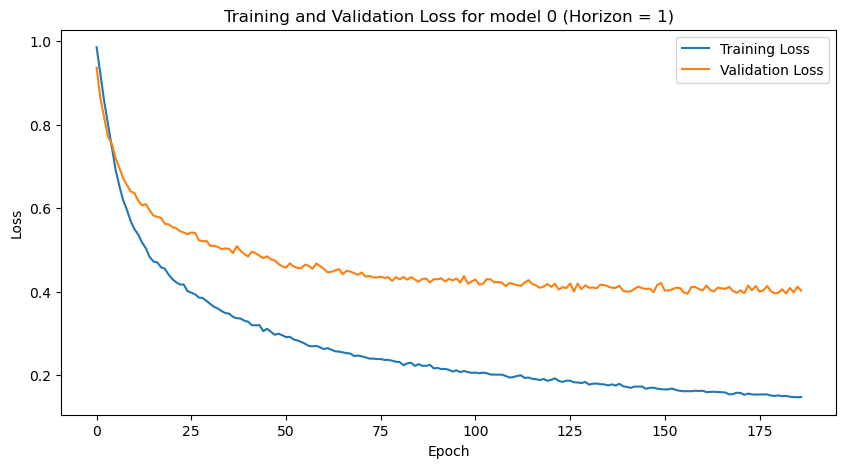

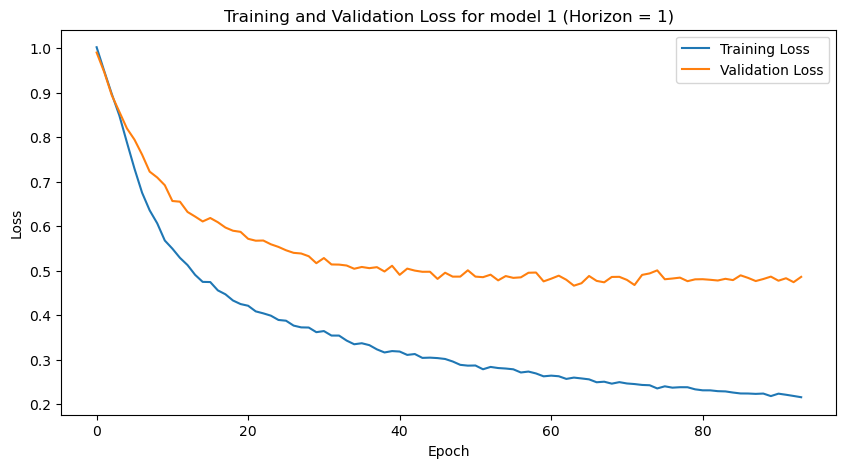

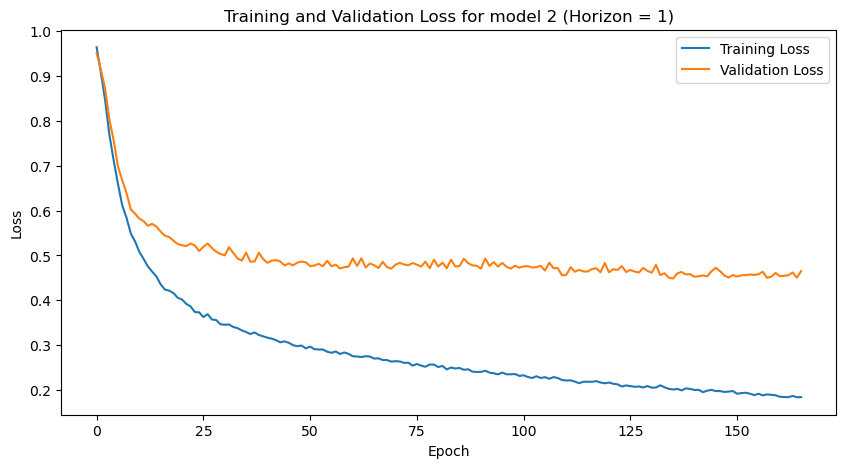

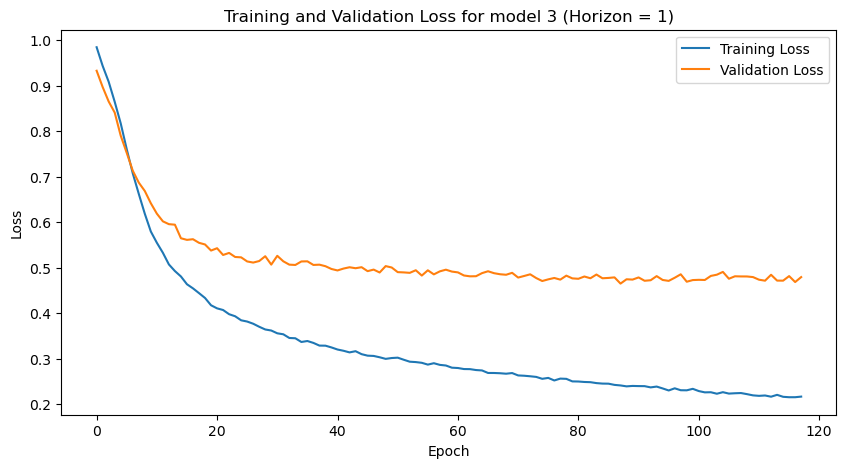

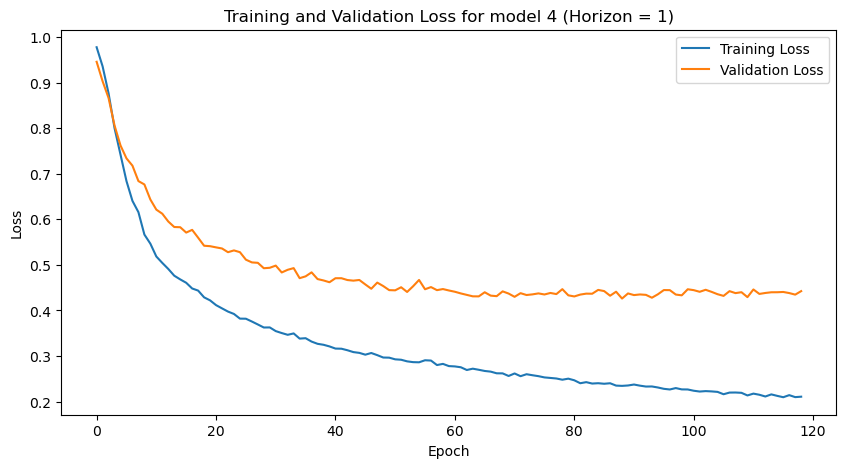

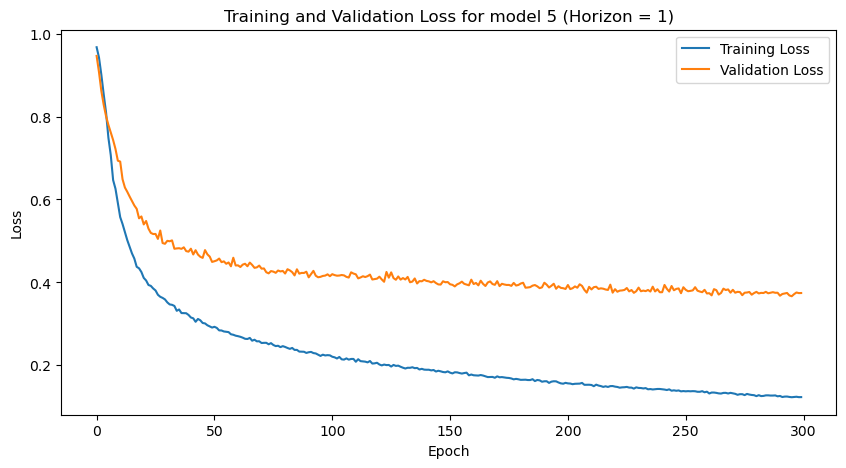

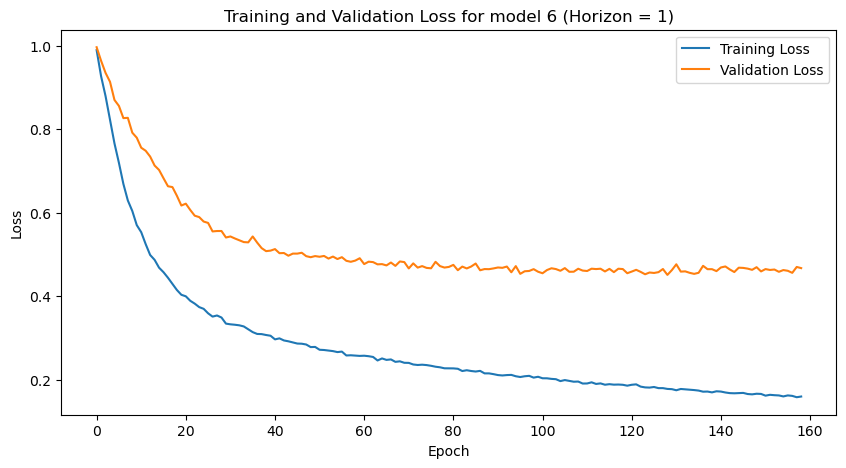

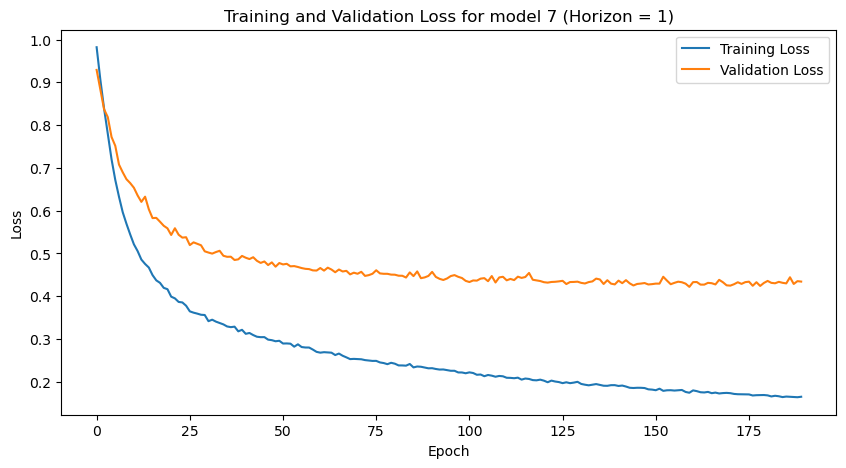

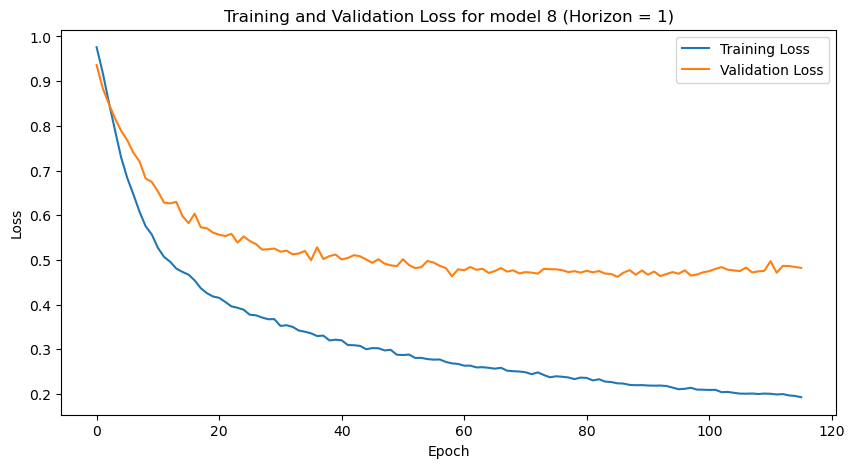

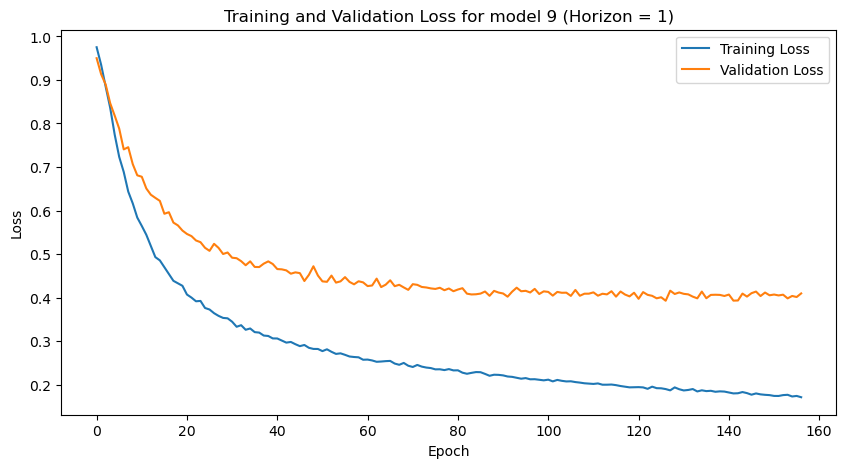

In [154]:
# Plot training and validation losses
for model_idx in range(n_models):
    plt.figure(figsize=(10, 5))
    plt.plot(horizon_results[model_idx]["training_history"]["train_losses"], label="Training Loss")
    plt.plot(horizon_results[model_idx]["training_history"]["val_losses"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss for model {model_idx} (Horizon = {horizon})")
    plt.legend()
    plt.show()

Evaluation on a particular test sequence


In [155]:
# Loading the specified model for prediction
model = tf.init_model(config)
model.load_state_dict(torch.load(horizon_results[test_model_idx]["model_path"], map_location=device))

# To avoid the error: Expected all tensors to be on the same device, but found at least two devices
model.to(device)

input_sq_name = folders["test_folders"][test_sequence_idx].split("/")[-1]
print(f"Using data from {input_sq_name} for testing")

# I need to recreate the loader for the test data because data_loaders["test"] contains the test data for all the test
# sequences concatenated - one just need to try:
# test_predictions, test_targets, _ = tf.eval_model(model, data_loaders["test"], device)
# print(f"test_predictions shape: {test_predictions.shape}")
# print(f"test_targets shape: {test_targets.shape}")

# # First option: starting from scratch
# sq_filename = os.path.join(workspace_dir, INPUT_SQ_DIR, input_sq_name, tf.DATA_FILENAME)
# time_data_mat = scipy.io.loadmat(sq_filename)
# test_signals = time_data_mat["org_data"]
# n_samples_test = test_signals.shape[1]
# test_data_scaled = scaler.transform(test_signals.T)
# X_test, y_test, test_indices = tf.create_multidim_sequences(test_data_scaled.T, seq_length, horizon)

# Second option (shorter): using the standardized_data that I computed previously:
test_data_scaled = standardized_data["test"][test_sequence_idx]
X_test, y_test, test_indices = test_data_scaled["X"], test_data_scaled["y"], test_data_scaled["indices"]

test_loader = tf.get_data_loader(X_test, y_test, batch_size, shuffle=False)
test_predictions, test_targets, _ = tf.eval_model(model, test_loader, device)
print(f"test_predictions shape: {test_predictions.shape}")
print(f"test_targets shape: {test_targets.shape}")

# Inverse standardization
test_predictions_rescaled = scaler.inverse_transform(test_predictions)
test_targets_rescaled = scaler.inverse_transform(test_targets)

Using data from 2. sq sl010 sag Xcs=125 3 cpts 2024 normalised for testing
test_predictions shape: (176, 3)
test_targets shape: (176, 3)


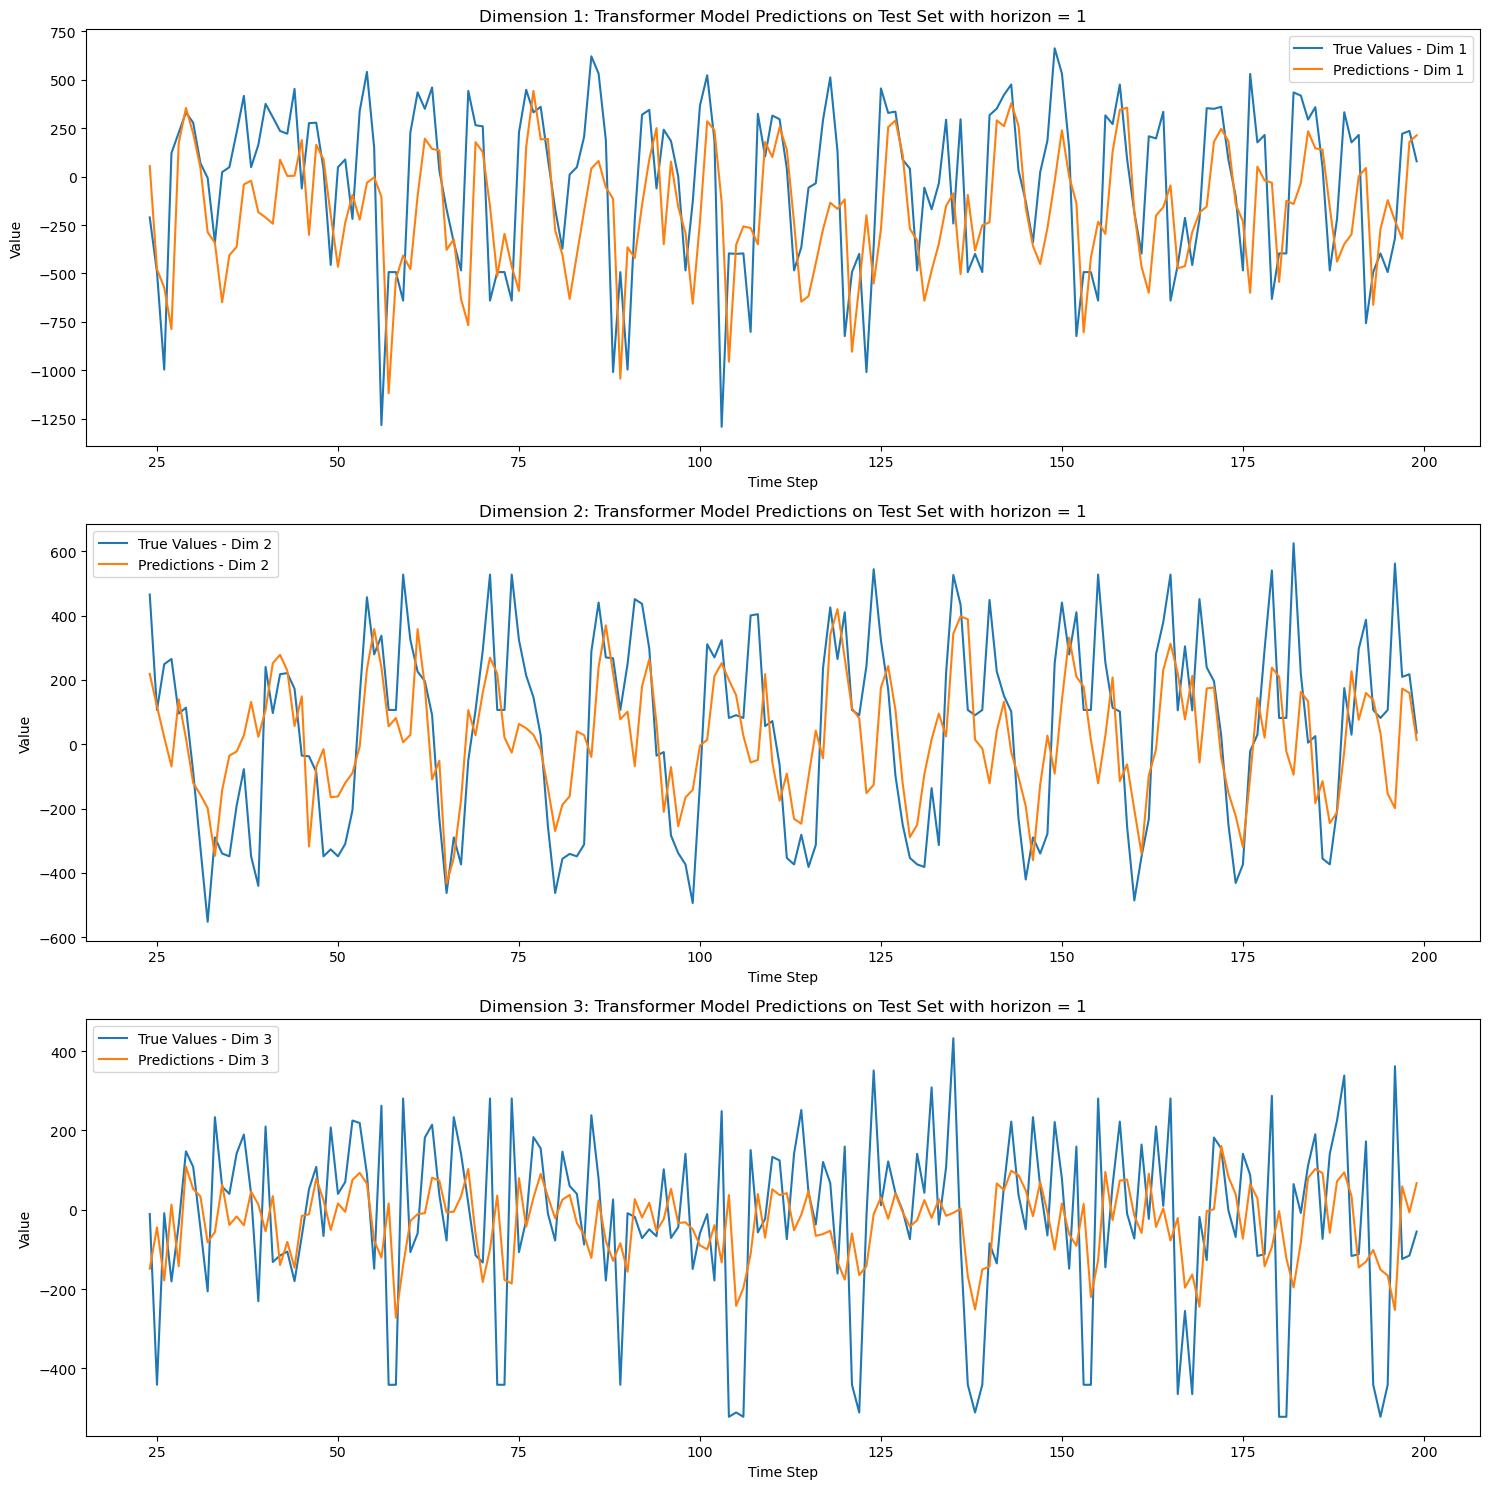

In [156]:
# Plot test predictions for each dimension
plt.figure(figsize=(15, 5 * n_features))
for i in range(n_features):
    plt.subplot(n_features, 1, i + 1)
    plt.plot(test_indices, test_targets_rescaled[:, i], label=f"True Values - Dim {i+1}")
    plt.plot(test_indices, test_predictions_rescaled[:, i], label=f"Predictions - Dim {i+1}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title(f"Dimension {i+1}: Transformer Model Predictions on Test Set with horizon = {horizon}")
    plt.legend()
plt.tight_layout()
plt.show()

In [157]:
# Calculate overall metrics across all dimensions
overall_mse = np.mean((test_predictions_rescaled - test_targets_rescaled) ** 2)
overall_rmse = np.sqrt(overall_mse)  # not the same as in Matlab / the paper
overall_mae = np.mean(np.abs(test_predictions_rescaled - test_targets_rescaled))

print(f"Overall performance metrics for horizon = {horizon}:")
print(f"Test MSE: {overall_mse:.4f}, RMSE: {overall_rmse:.4f}, MAE: {overall_mae:.4f}")

Overall performance metrics for horizon = 1:
Test MSE: 92654.0469, RMSE: 304.3913, MAE: 226.4347


Redoing the prediction, but this time with adaptive scaling - to help cope with low variations in training data and
potential distribution gap between training and testing...


In [158]:
from sklearn.preprocessing import StandardScaler


# I need to load my input sequence from scratch
sq_filename = os.path.join(workspace_dir, INPUT_SQ_DIR, input_sq_name, tf.DATA_FILENAME)
time_data_mat = scipy.io.loadmat(sq_filename)
test_sequence = time_data_mat["org_data"]

adaptive_test_scaler = StandardScaler()  # here it is adaptive in the sense that it is fitted using the first datapoints
adaptation_data = test_sequence[:, :adaptation_window]
adaptive_test_scaler.fit(adaptation_data.T)
test_sequence_scaled = adaptive_test_scaler.transform(test_sequence.T)

X_test, y_test, test_indices = tf.create_multidim_sequences(test_sequence_scaled.T, seq_length, horizon)

In [159]:
# then it's the same code as above - probably refactor that

test_loader = tf.get_data_loader(X_test, y_test, batch_size, shuffle=False)
test_predictions, test_targets, _ = tf.eval_model(model, test_loader, device)
print(f"test_predictions shape: {test_predictions.shape}")
print(f"test_targets shape: {test_targets.shape}")

# Inverse standardization
test_predictions_rescaled = adaptive_test_scaler.inverse_transform(test_predictions)
test_targets_rescaled = adaptive_test_scaler.inverse_transform(test_targets)

test_predictions shape: (176, 3)
test_targets shape: (176, 3)


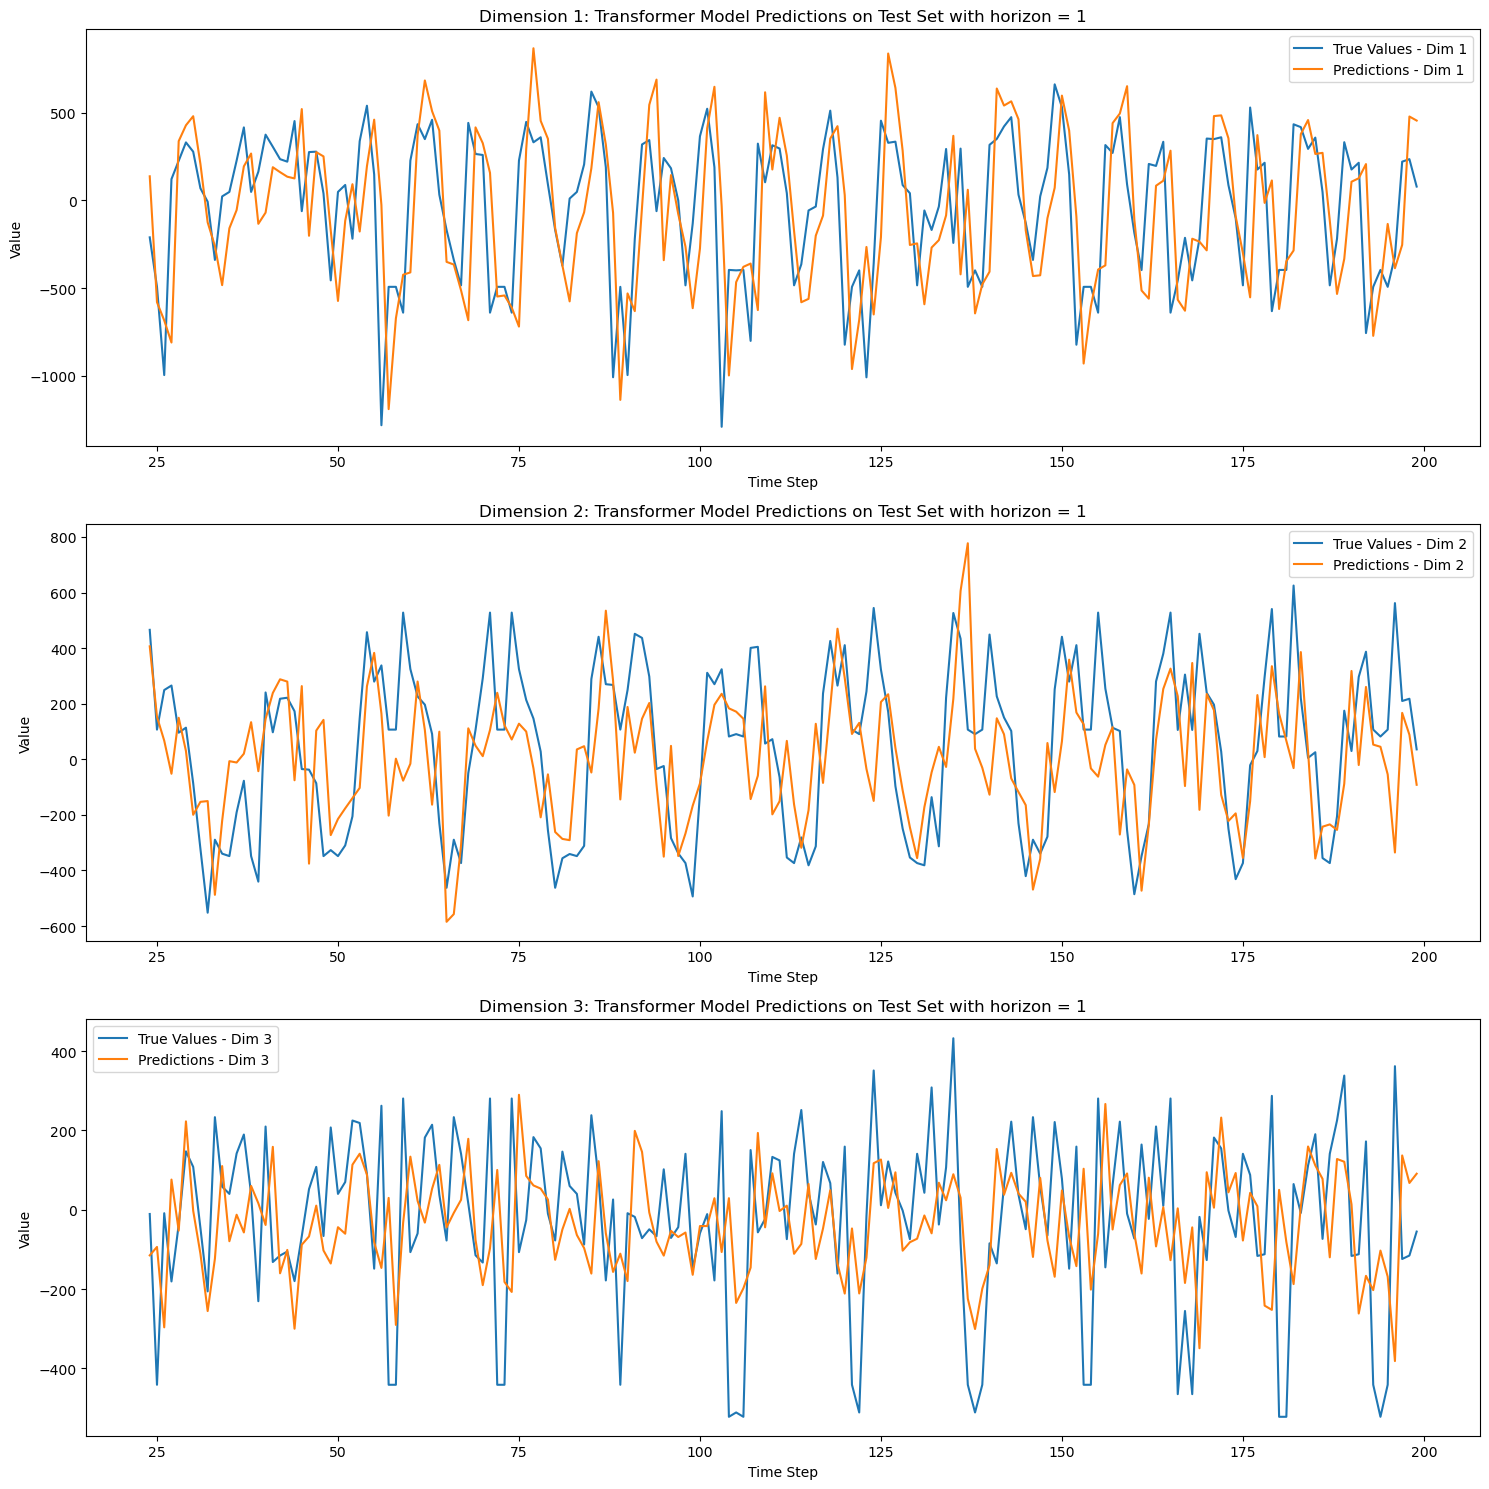

In [160]:
# Plot test predictions for each dimension - again, extract that as a function
plt.figure(figsize=(15, 5 * n_features))
for i in range(n_features):
    plt.subplot(n_features, 1, i + 1)
    plt.plot(test_indices, test_targets_rescaled[:, i], label=f"True Values - Dim {i+1}")
    plt.plot(test_indices, test_predictions_rescaled[:, i], label=f"Predictions - Dim {i+1}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title(f"Dimension {i+1}: Transformer Model Predictions on Test Set with horizon = {horizon}")
    plt.legend()
plt.tight_layout()
plt.show()

In [161]:
# Calculate overall metrics across all dimensions
overall_mse = np.mean((test_predictions_rescaled - test_targets_rescaled) ** 2)
overall_rmse = np.sqrt(overall_mse)
overall_mae = np.mean(np.abs(test_predictions_rescaled - test_targets_rescaled))

print(f"Overall performance metrics for horizon = {horizon}:")
print(f"Test MSE: {overall_mse:.4f}, RMSE: {overall_rmse:.4f}, MAE: {overall_mae:.4f}")

Overall performance metrics for horizon = 1:
Test MSE: 103162.8438, RMSE: 321.1897, MAE: 241.0262


In [162]:
# Auxiliary function - not sure yet about it but keeping that here in case...

import json


def load_model(model_path, config_path, device):
    """Load a trained model and its configuration"""
    # Load configuration
    with open(config_path, "r") as f:
        config = json.load(f)

    # Initialize model
    model = tf.init_model(config)

    # Load model weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set model to evaluation mode

    return model, config


horizon_dir = os.path.join(model_output_dir, f"horizon_{horizon}")